In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as cx
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
import esda as esda
from esda.moran import Moran_Local
import splot as splot
from libpysal.weights.contiguity import Queen
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from splot.esda import plot_local_autocorrelation
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 16]

In [2]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [3]:
geogon_od = pd.read_csv('geogon_od.csv')
geogon_od = geogon_od[(geogon_od['Year'] >= 2010) & (geogon_od['Year'] <= 2019)]

# Rename our columns to have spaces 
geogon_od.columns = ['Year', 'FIPS', 'State', 'County', 'Deaths', 'Population', 'Crude_Rate',
       'Cruder_Rate', 'Deathrate_per_100', 'Unemployment_rate',
       'Dispense_rate', 'SUMLEV', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
       'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
       'TOM_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE',
       'Urbanicity', 'Jail_Population', 'Incarceration_Rate_per_100k',
       'PovertyCount', 'PovertyPercentage', 'MedianHHI', 'Latitude',
       'Longitude', 'geometry']

nonnum_features = ['Year', 'FIPS', 'State', 'County', 'Urbanicity', 'Latitude',
                   'Longitude', 'geometry']
geogon_od = geogon_od.drop(['AGEGRP', 'Crude_Rate', 'SUMLEV'], axis = 1)
cruder_rate = geogon_od['Cruder_Rate']
stzd_geogon = standardize(geogon_od.drop(nonnum_features, axis = 1))
stzd_geogon['Cruder_Rate'] = cruder_rate
stzd_geogon[nonnum_features] = geogon_od[nonnum_features]

# Convert to geopandas 
stzd_geogon['geometry'] = gpd.GeoSeries.from_wkt(stzd_geogon['geometry'])
stzd_geogon = gpd.GeoDataFrame(stzd_geogon, geometry = 'geometry')

# Convert FIPS to string 
stzd_geogon['FIPS'] = stzd_geogon['FIPS'].astype(str).str.zfill(5)

In [4]:
y, X = dmatrices("Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + \
H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + \
TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + \
Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI", 
                 data=stzd_geogon, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            Cruder_Rate   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     67.58
Date:                Sat, 19 Mar 2022   Prob (F-statistic):          4.76e-240
Time:                        21:12:59   Log-Likelihood:                -30083.
No. Observations:                7591   AIC:                         6.021e+04
Df Residuals:                    7571   BIC:                         6.035e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [5]:
stzd_geogon = stzd_geogon.dropna()
stzd_geogon = stzd_geogon.reset_index(drop = True)
w = Queen.from_dataframe(stzd_geogon)

stzd_geogon_2 = stzd_geogon.drop(w.islands)
w2 = Queen.from_dataframe(stzd_geogon_2)

y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.4608545578936905

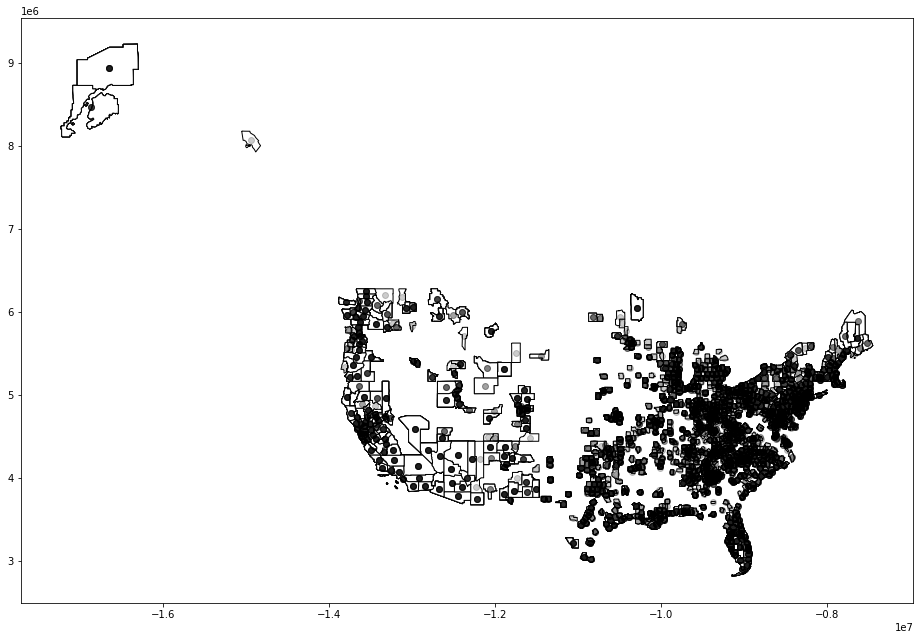

In [6]:
stzd_geogon.crs = "EPSG:4326"
gdf_3857 = stzd_geogon.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

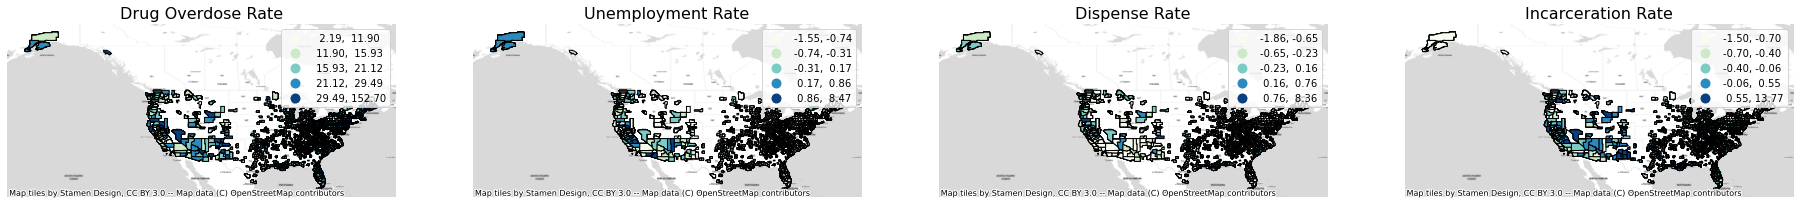

In [7]:
f,ax = plt.subplots(1,4,figsize=(32,34))

stzd_geogon.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

stzd_geogon.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

stzd_geogon.plot(column='Dispense_rate', legend=True, ax=ax[2],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[2].set_title("Dispense Rate", fontsize=16)

stzd_geogon.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[3],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[3].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')

cx.add_basemap(ax[0], crs=stzd_geogon.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=stzd_geogon.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[2], crs=stzd_geogon.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[3], crs=stzd_geogon.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

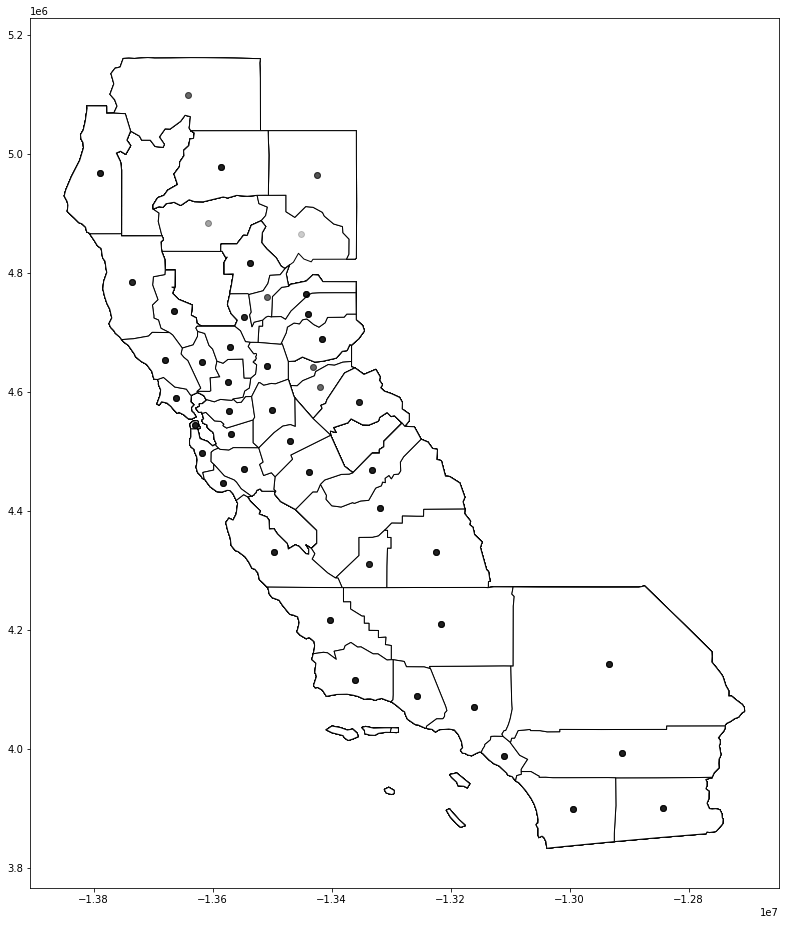

In [8]:
california = stzd_geogon[stzd_geogon['State'] == 'California']
california.crs = "EPSG:4326"
gdf_3857 = california.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

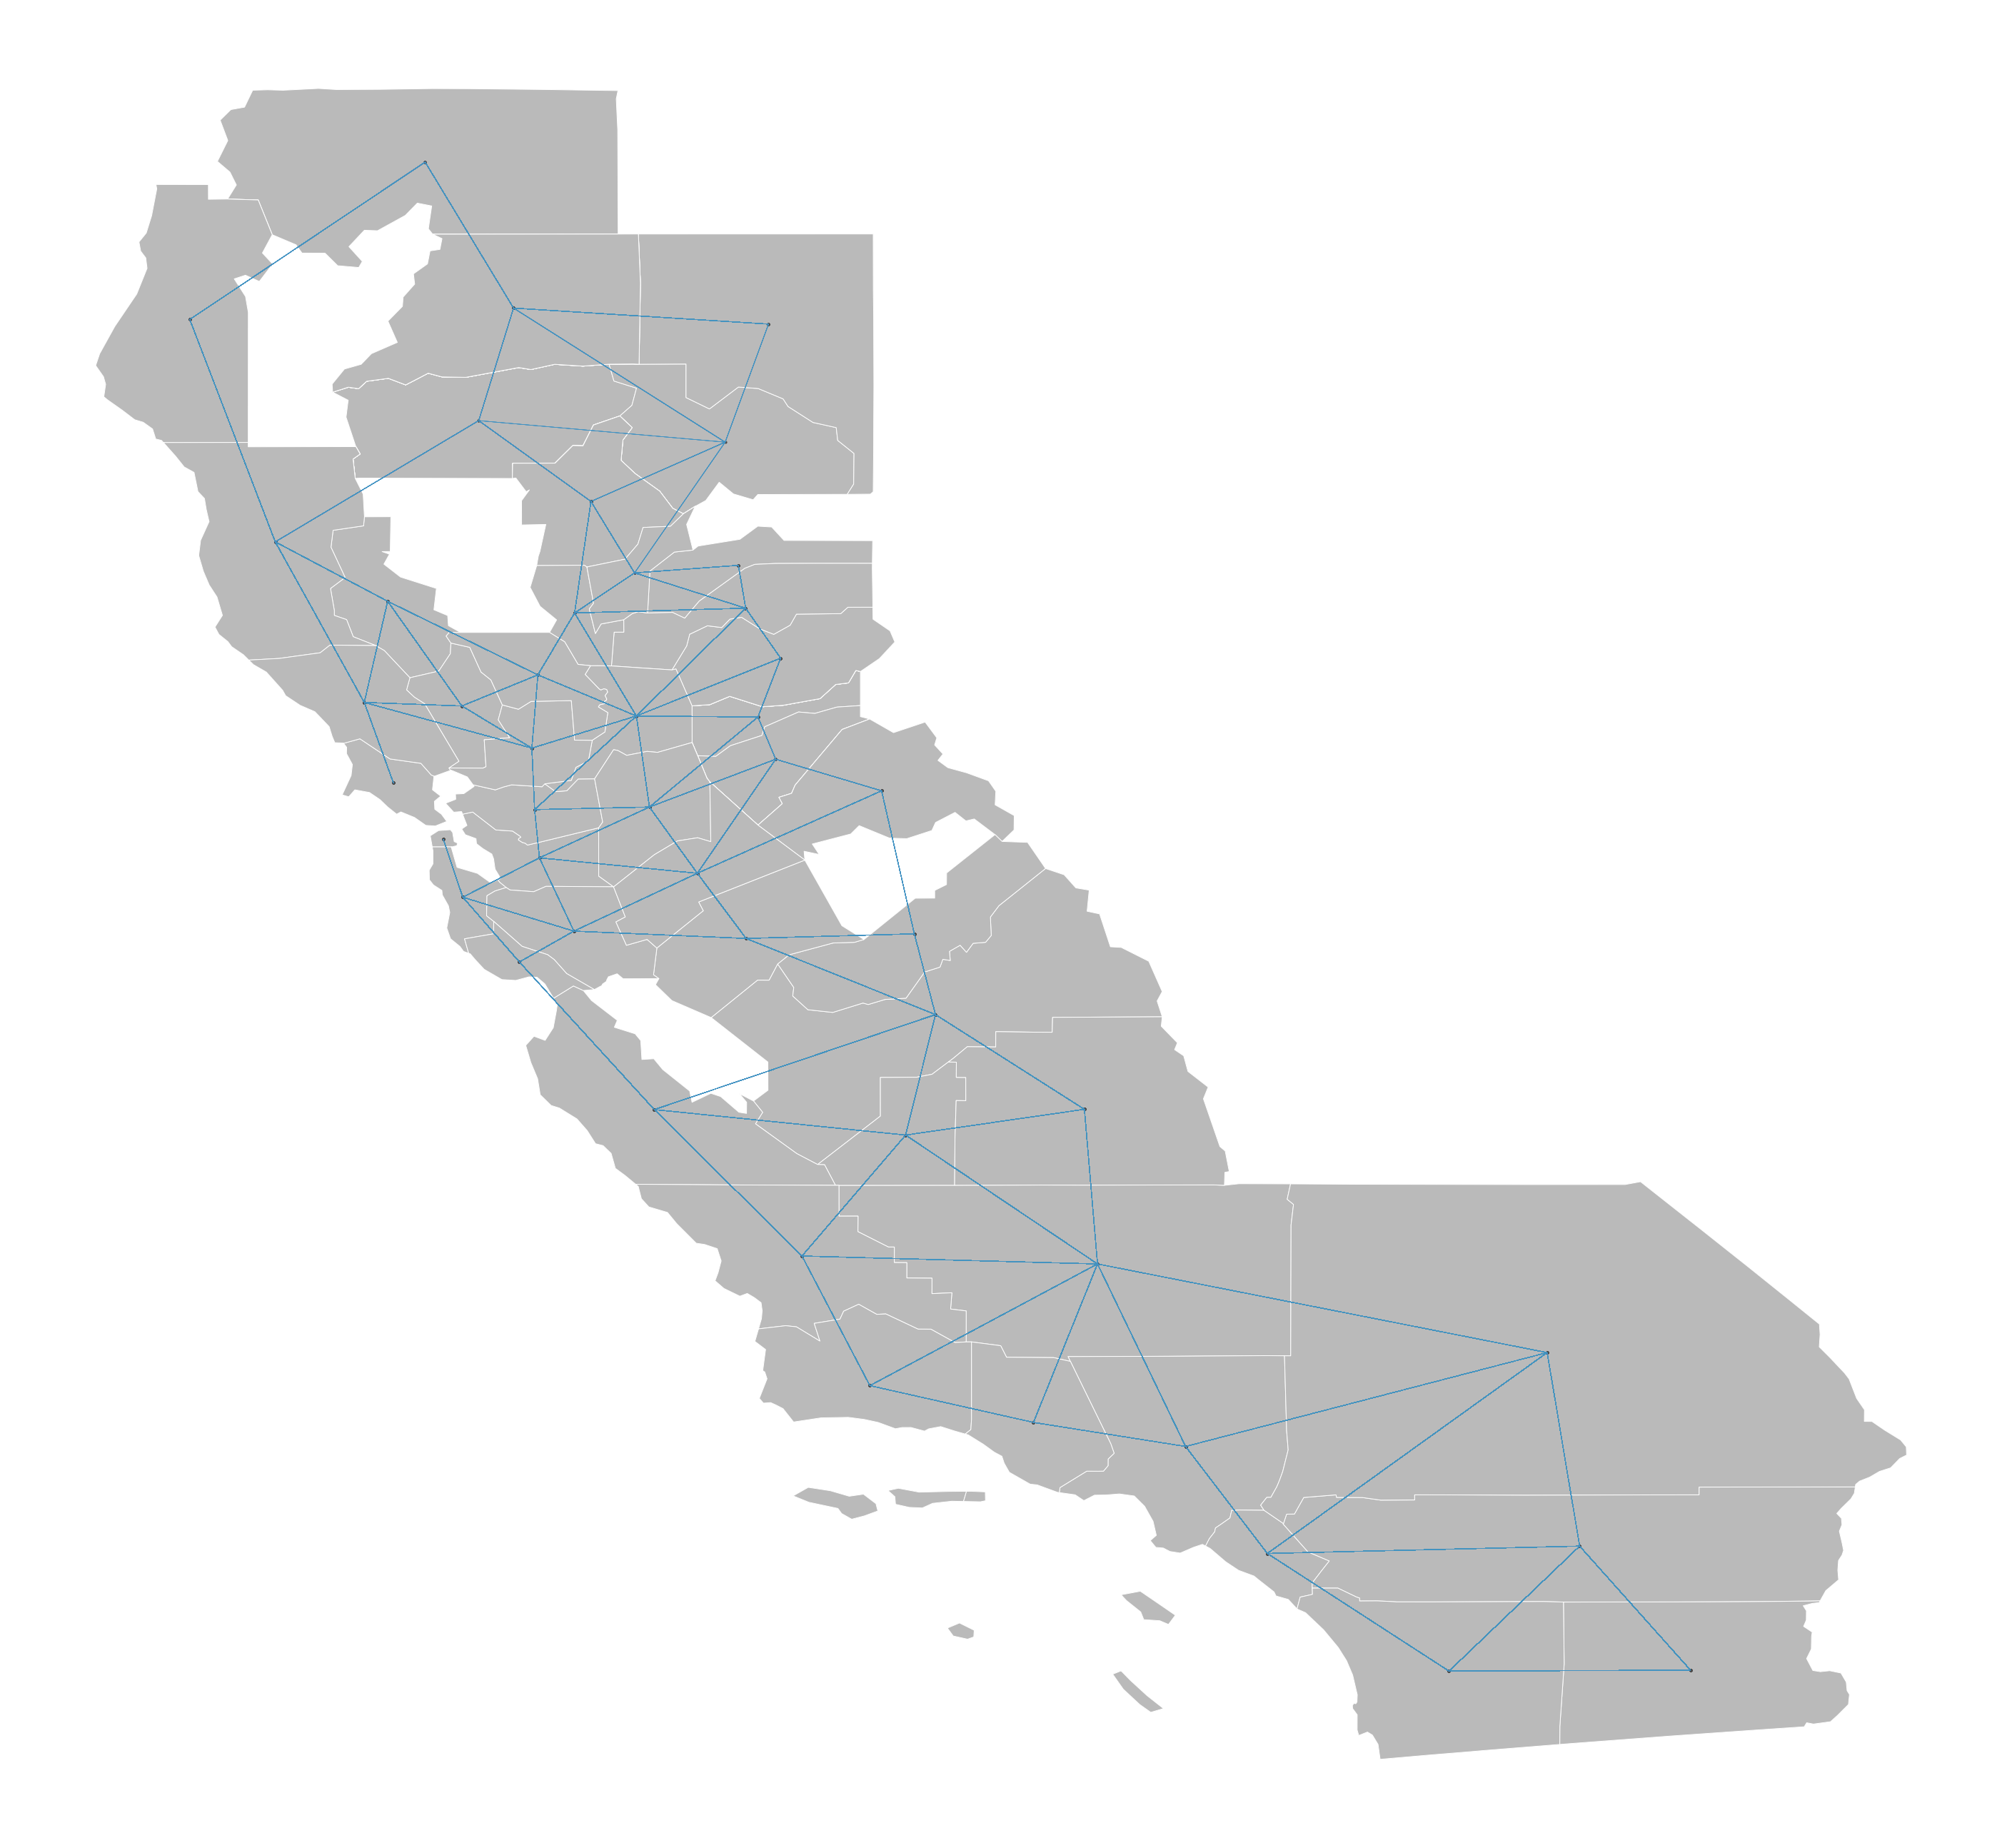

In [9]:
cali_df = stzd_geogon[stzd_geogon['State'] == 'California']
cali_w = Queen.from_dataframe(cali_df)
plot_spatial_weights(cali_w, cali_df, figsize = (50, 50))

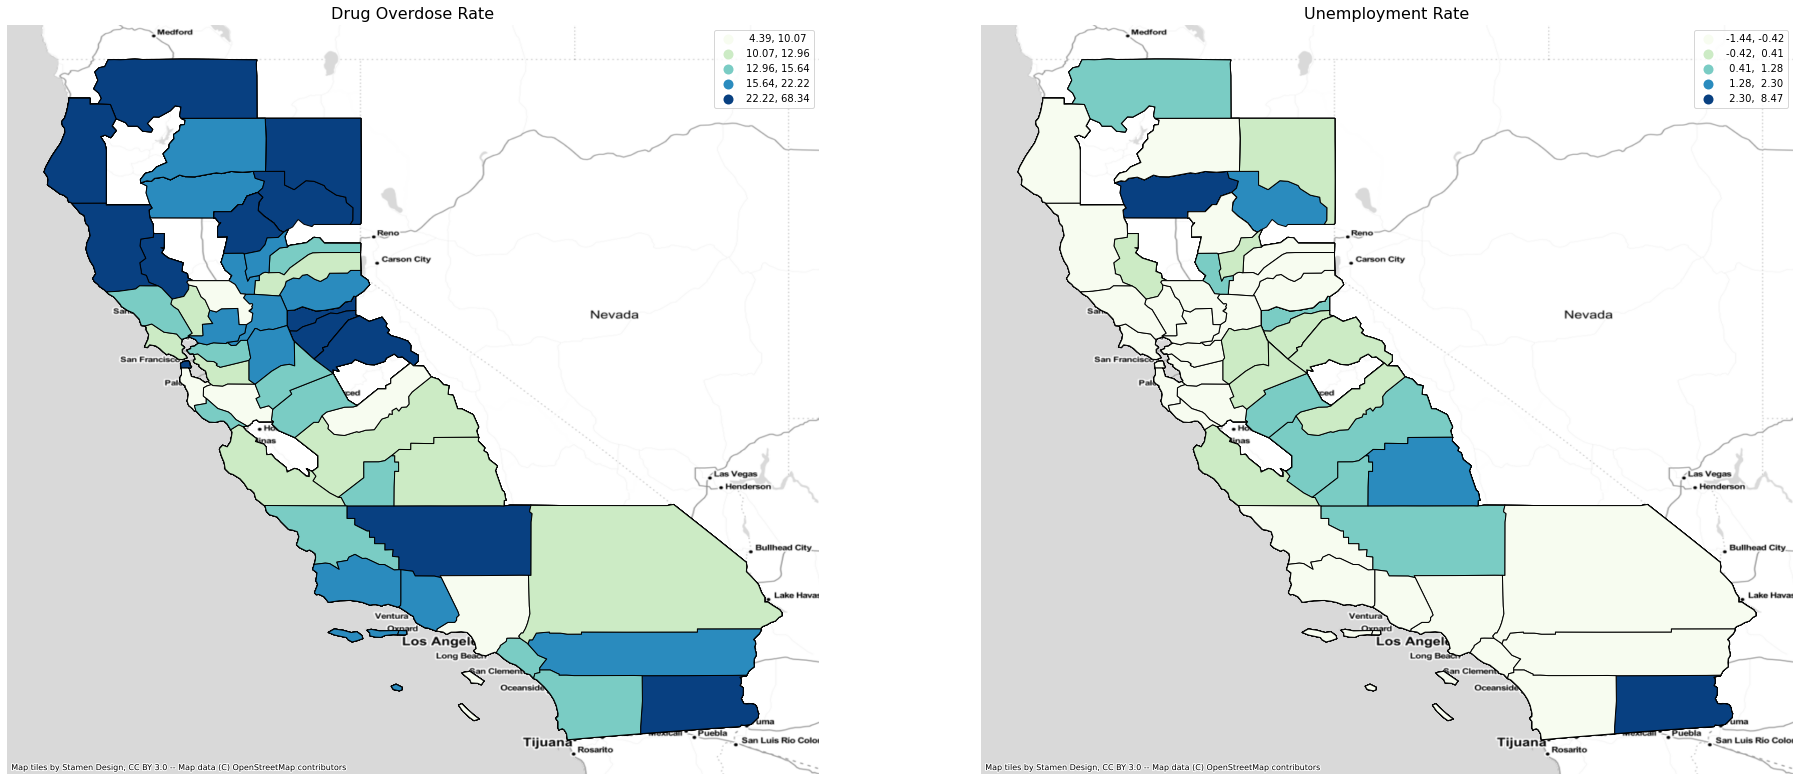

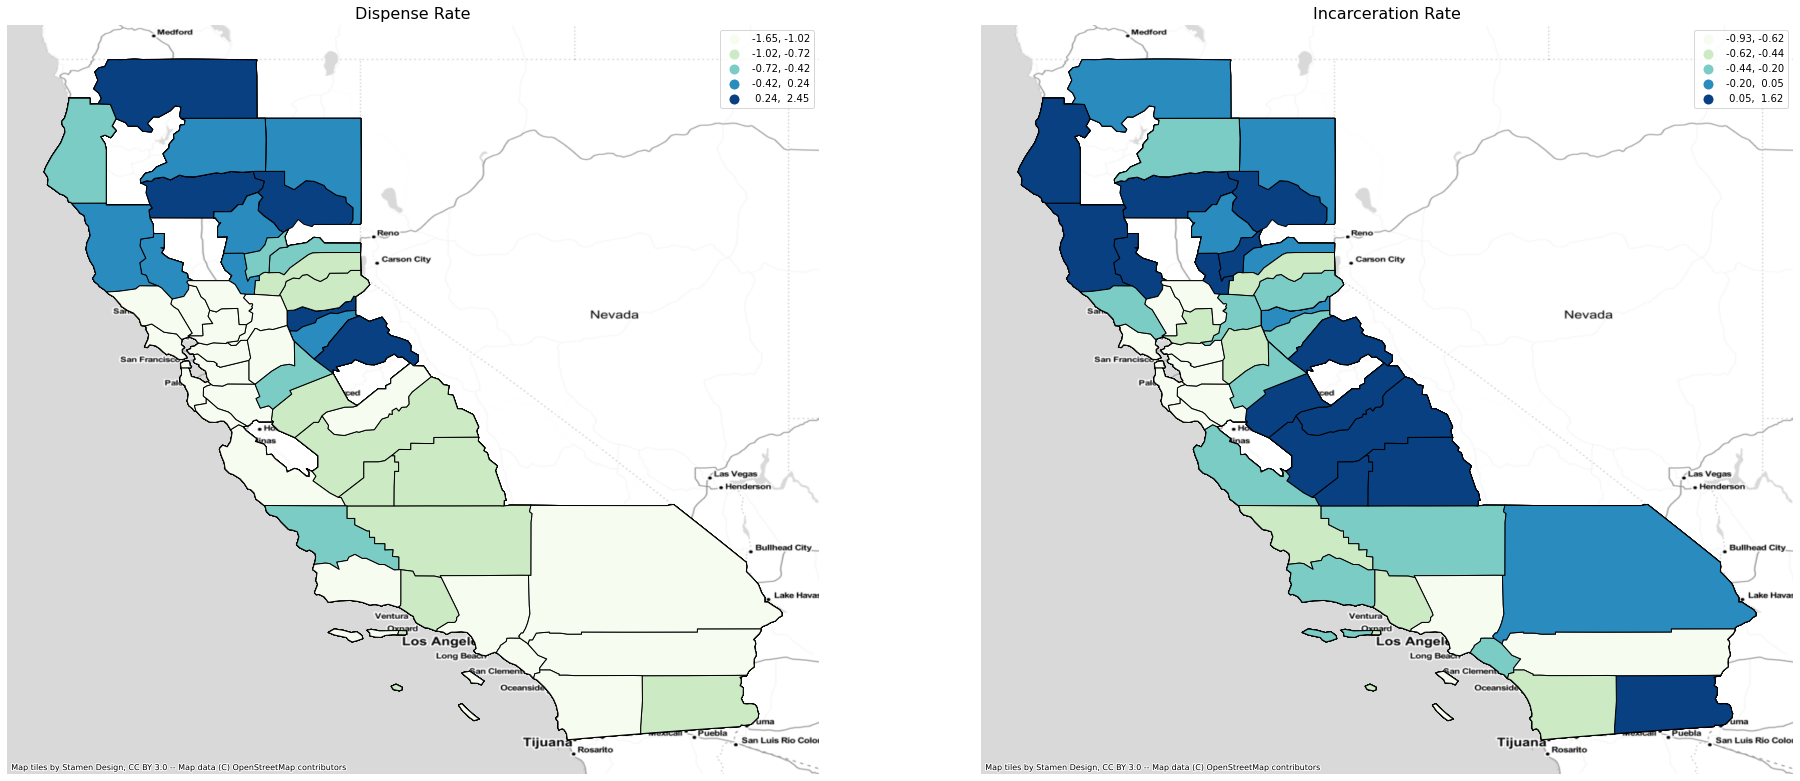

In [10]:
f,ax = plt.subplots(1,2,figsize=(32,34))

california.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

california.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

f,ax = plt.subplots(1,2,figsize=(32,34))
california.plot(column='Dispense_rate', legend=True, ax=ax[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[0].set_title("Dispense Rate", fontsize=16)

california.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

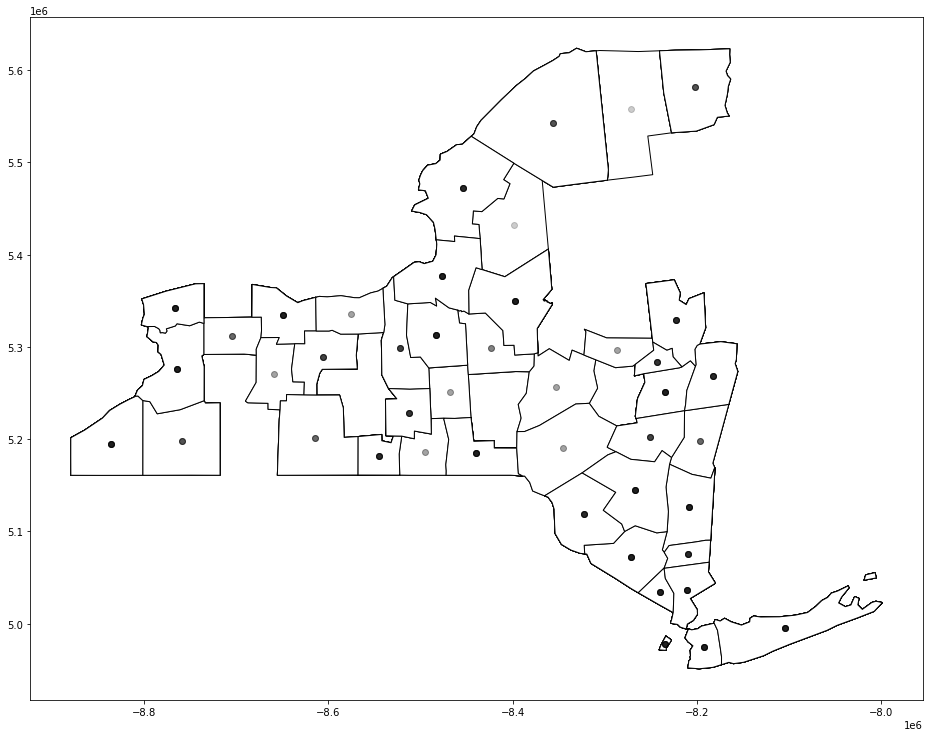

In [11]:
california = stzd_geogon[stzd_geogon['State'] == 'New York']
california.crs = "EPSG:4326"
gdf_3857 = california.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

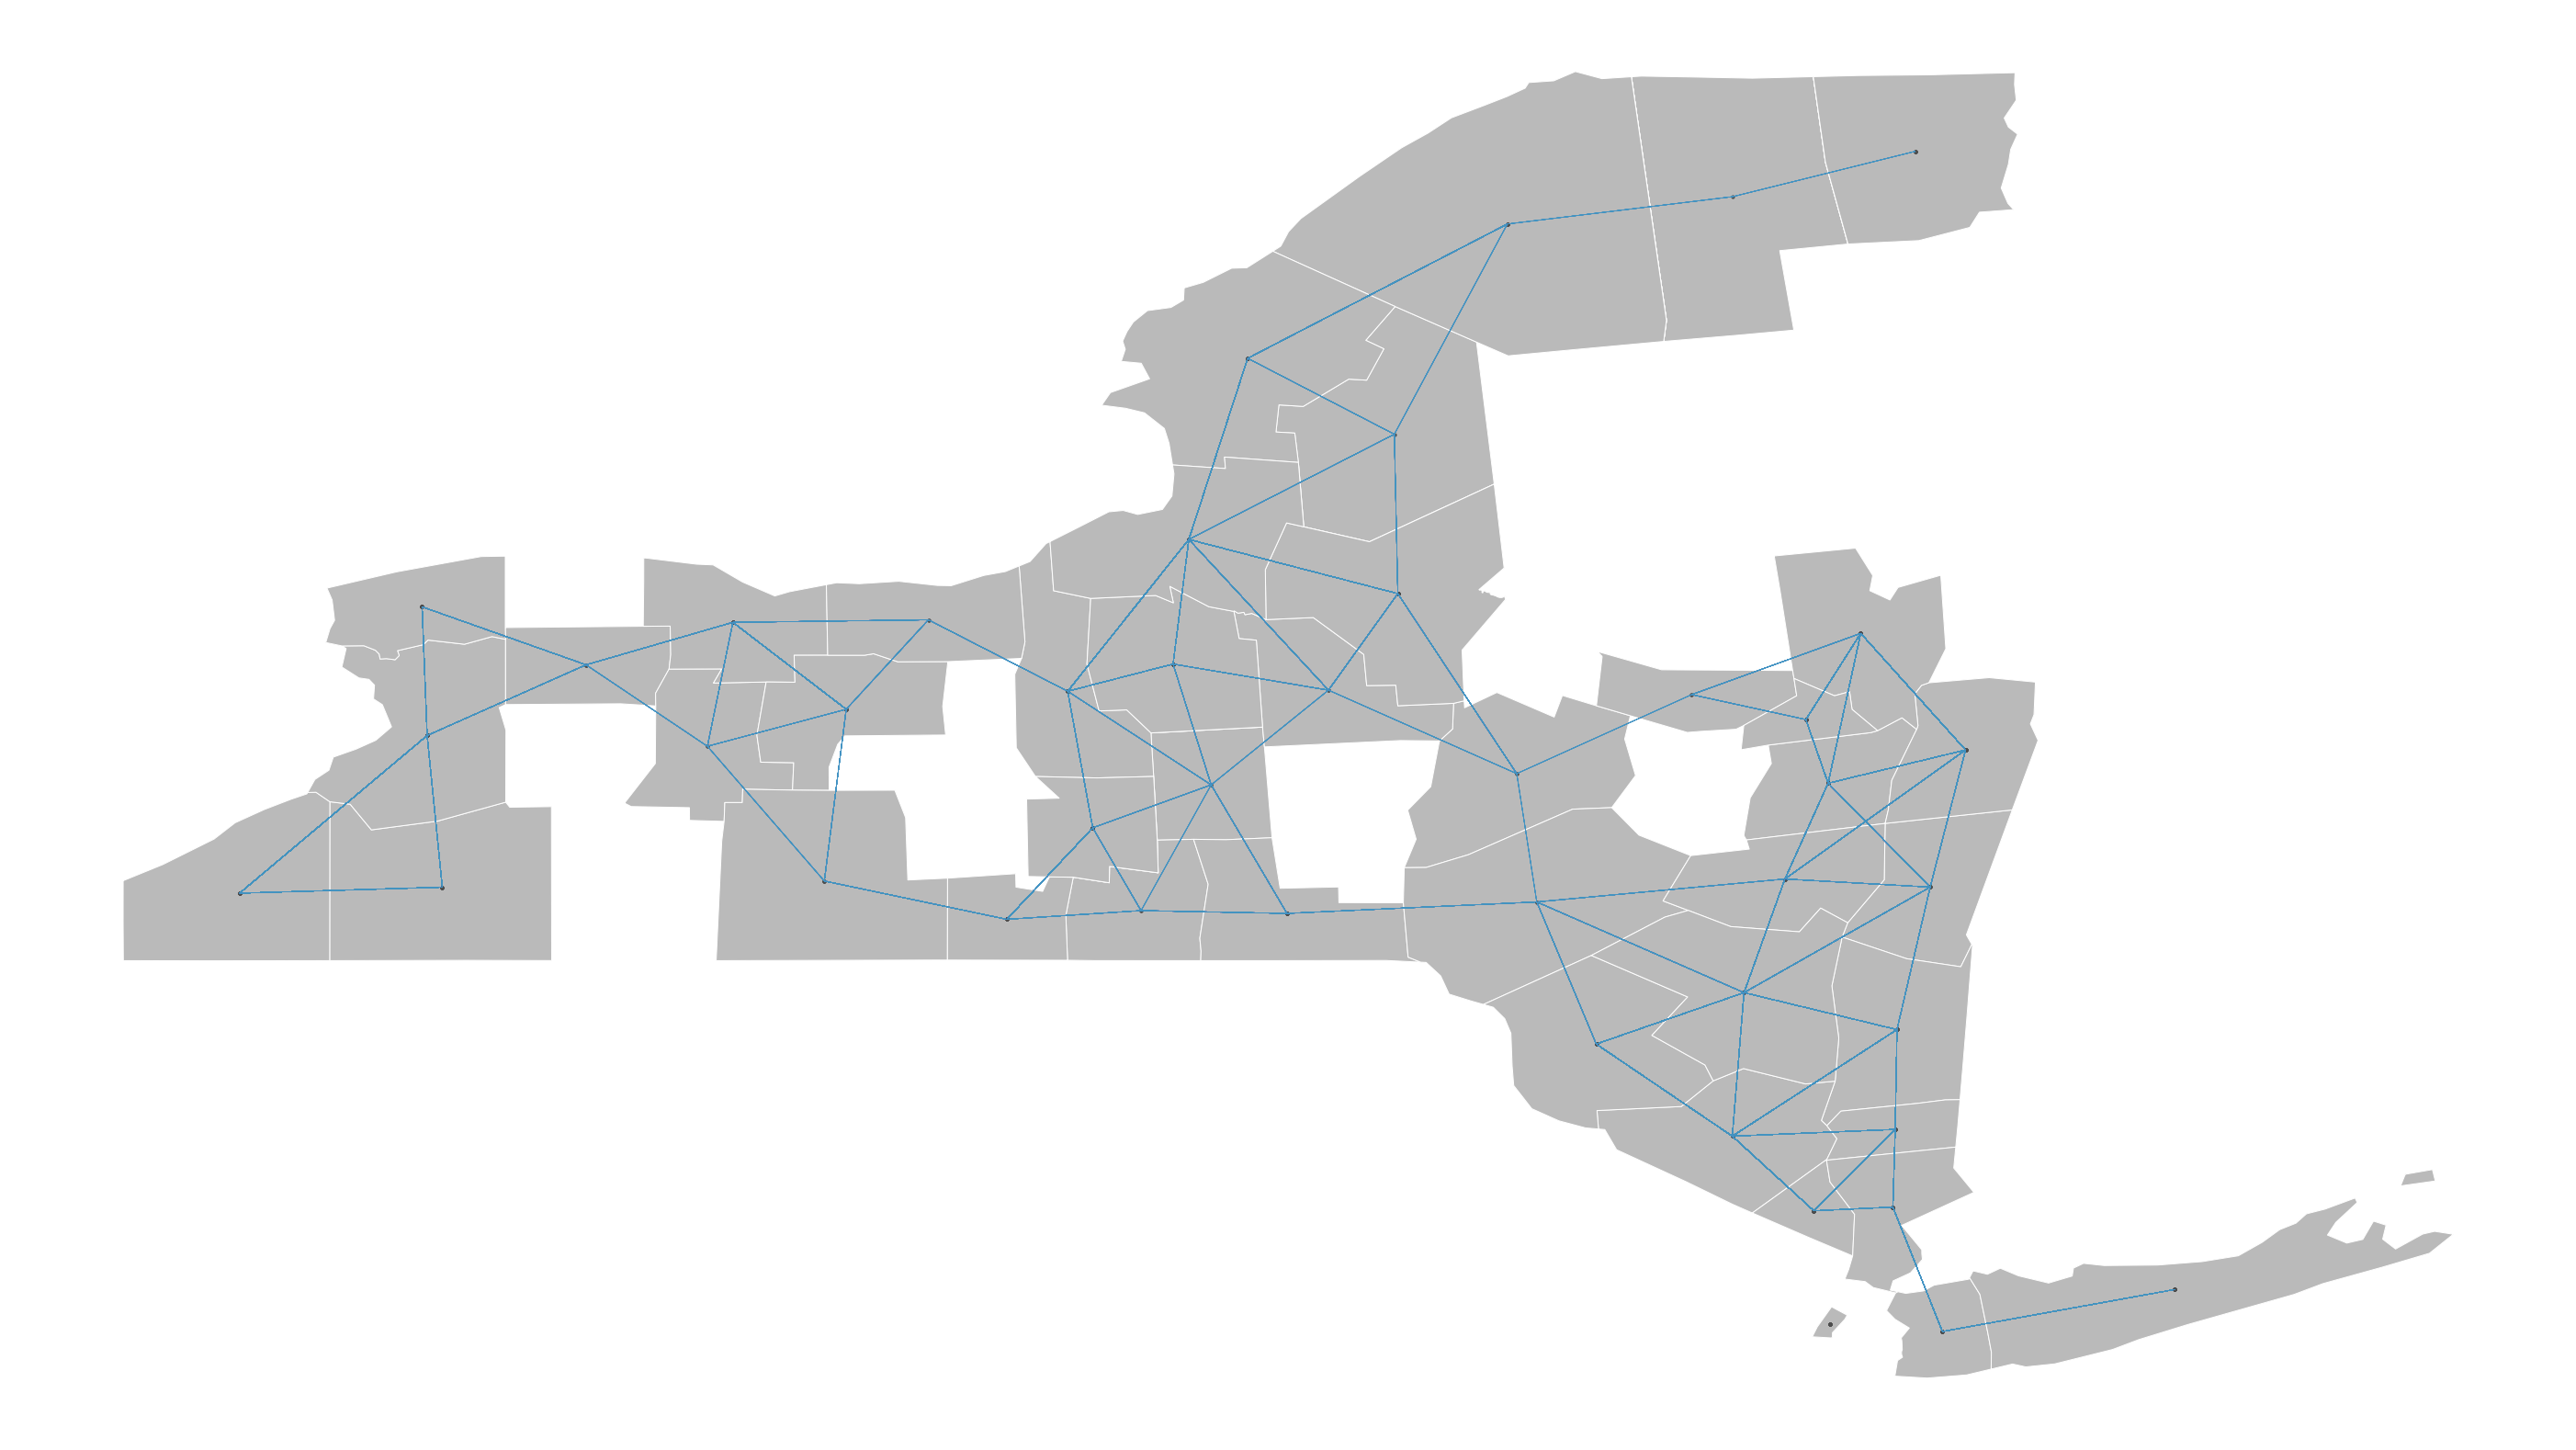

In [12]:
ny_df = stzd_geogon[stzd_geogon['State'] == 'New York']
ny_w = Queen.from_dataframe(ny_df)
plot_spatial_weights(ny_w, ny_df, figsize = (50,50))

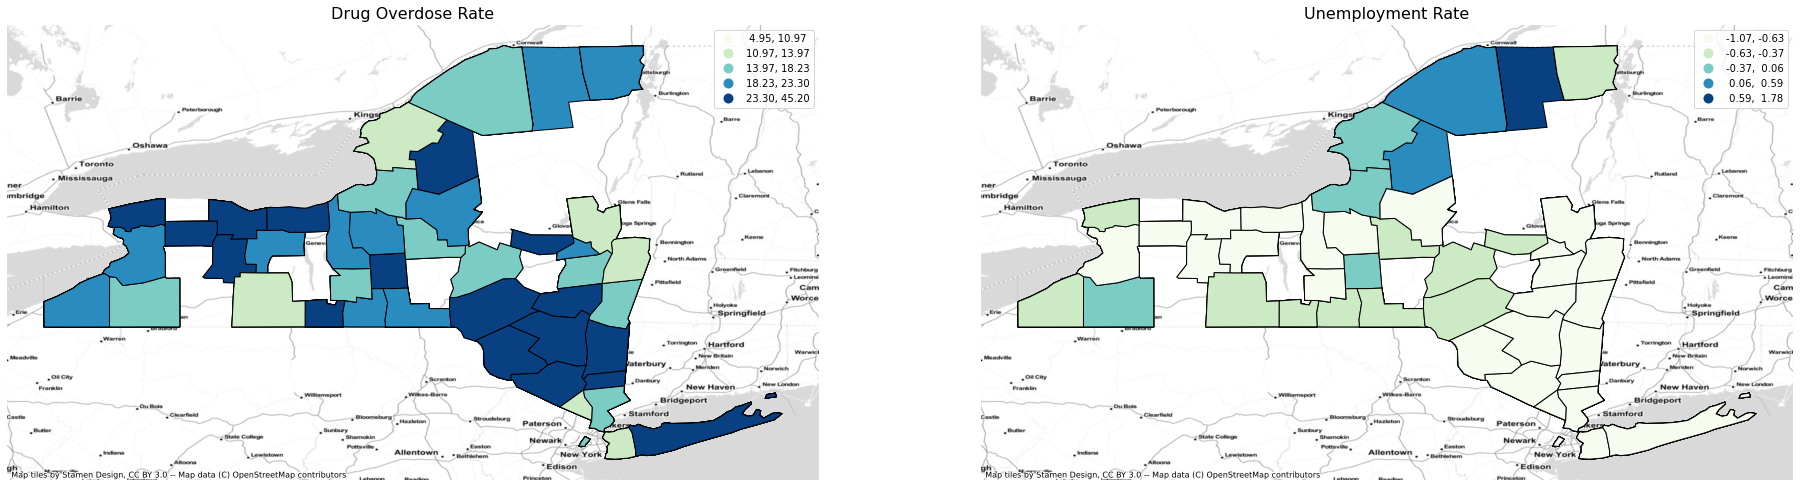

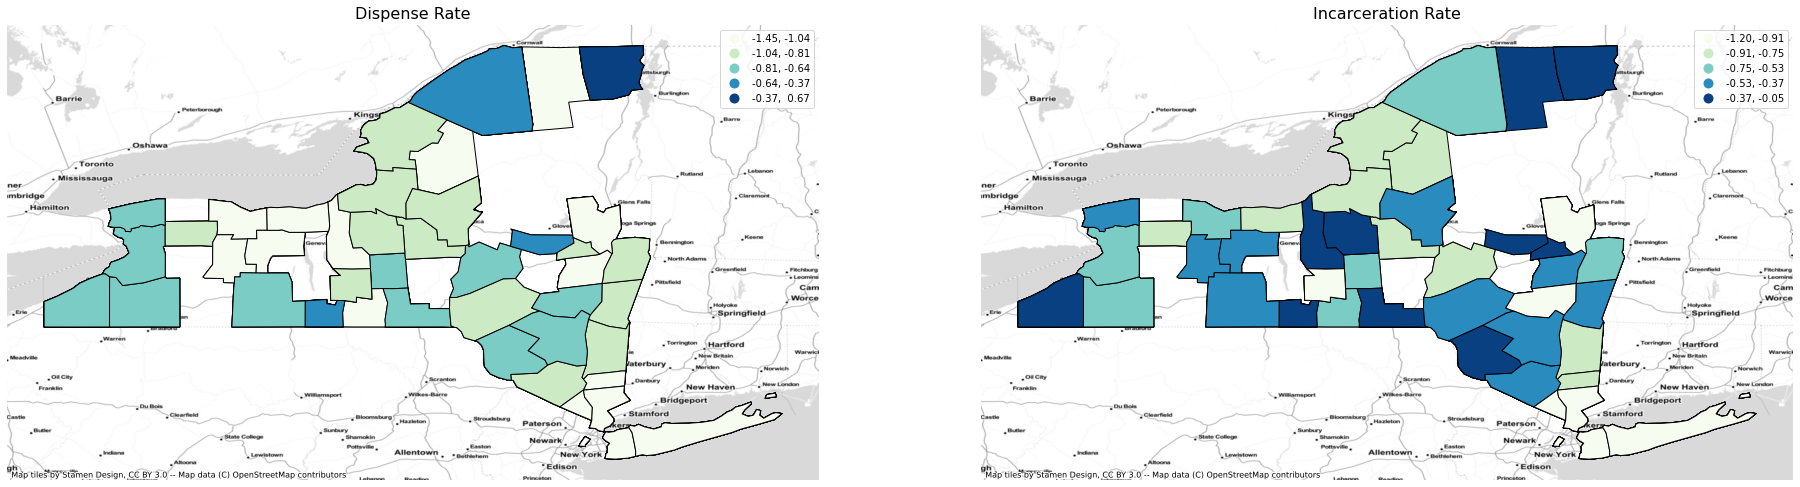

In [13]:
f,ax = plt.subplots(1,2,figsize=(32,34))

california.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

california.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

f,ax = plt.subplots(1,2,figsize=(32,34))
california.plot(column='Dispense_rate', legend=True, ax=ax[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[0].set_title("Dispense Rate", fontsize=16)

california.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

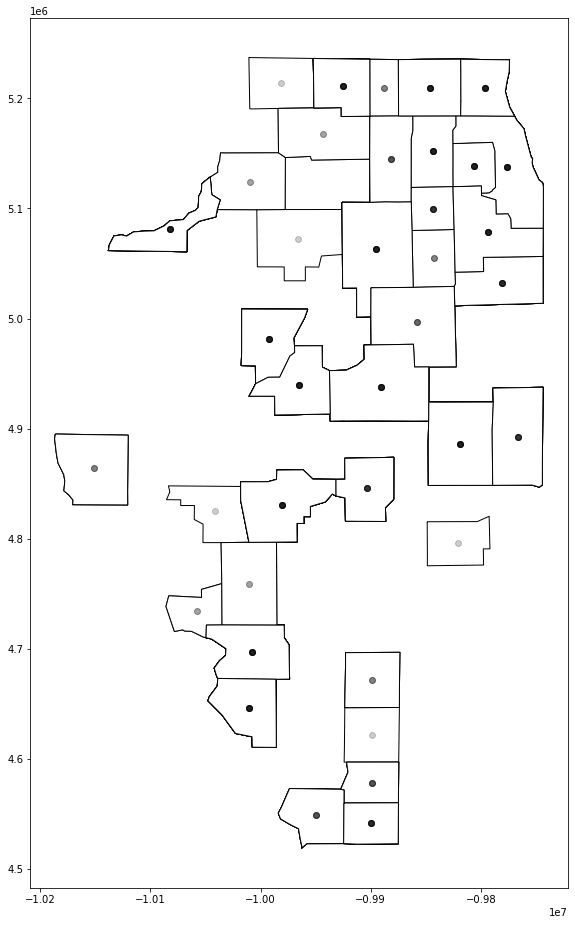

In [14]:
california = stzd_geogon[stzd_geogon['State'] == 'Illinois']
california.crs = "EPSG:4326"
gdf_3857 = california.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

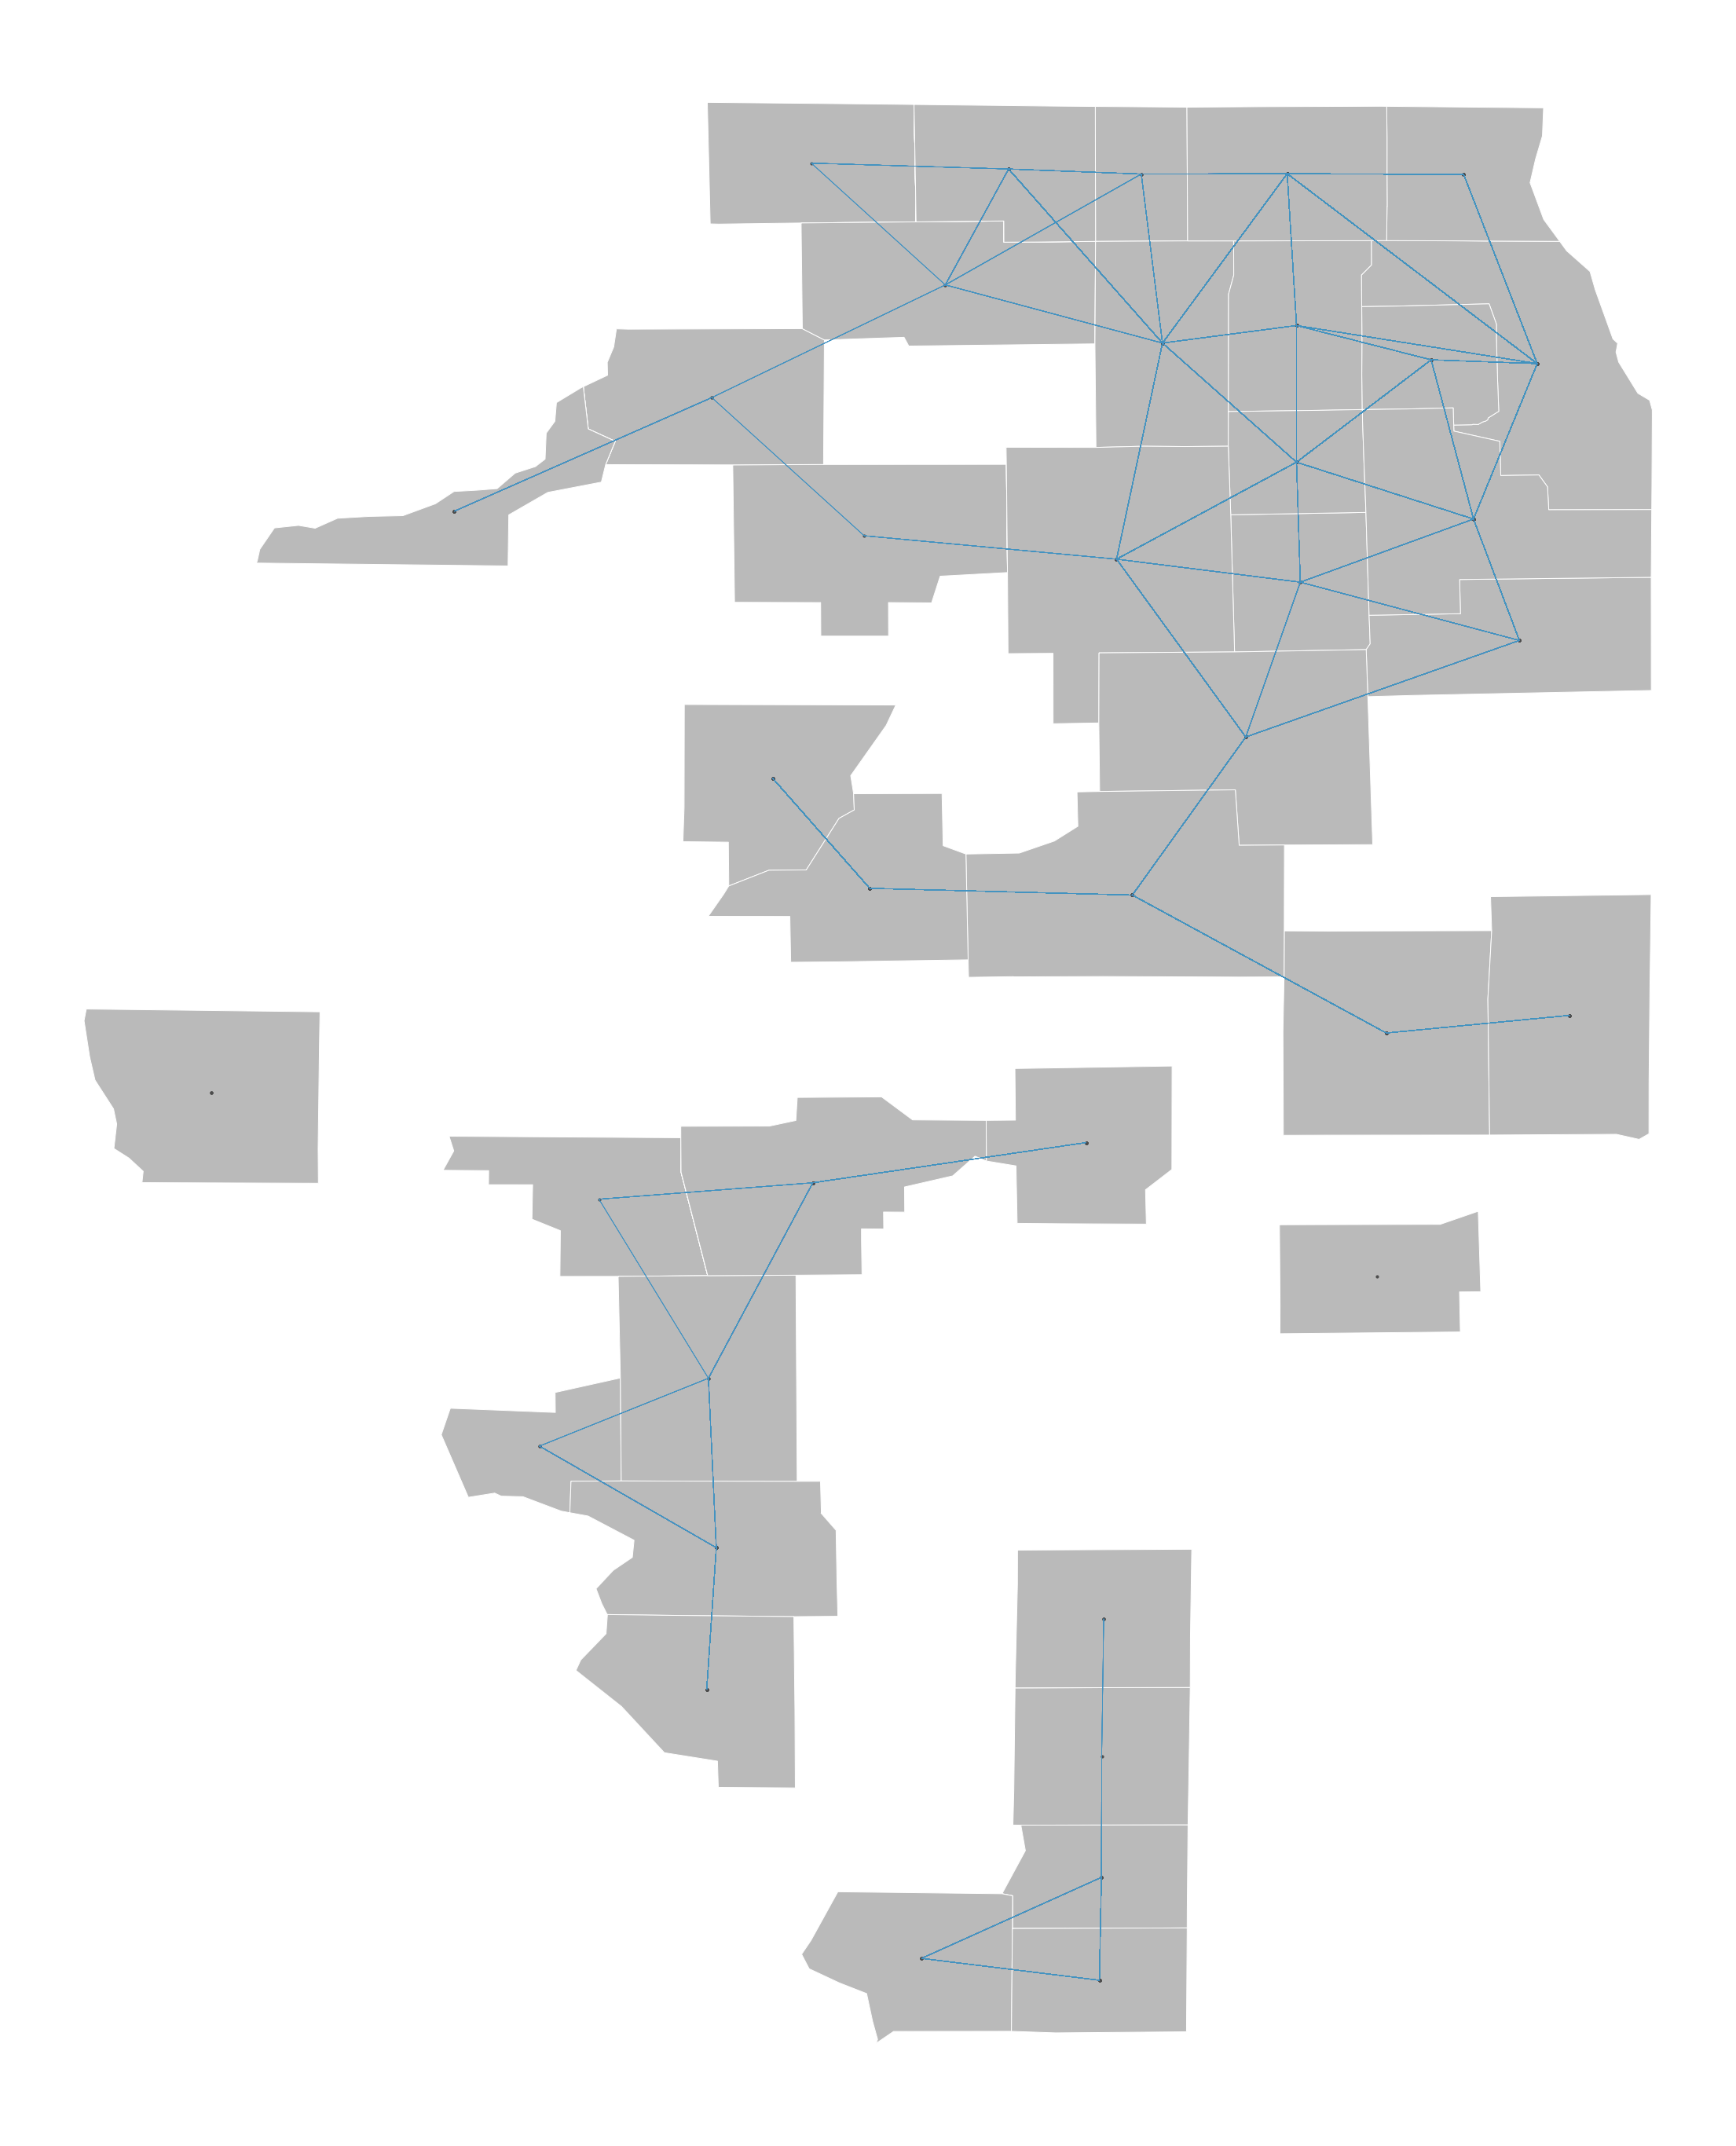

In [15]:
cali_df = stzd_geogon[stzd_geogon['State'] == 'Illinois']
cali_w = Queen.from_dataframe(cali_df)
plot_spatial_weights(cali_w, cali_df, figsize = (50, 50))

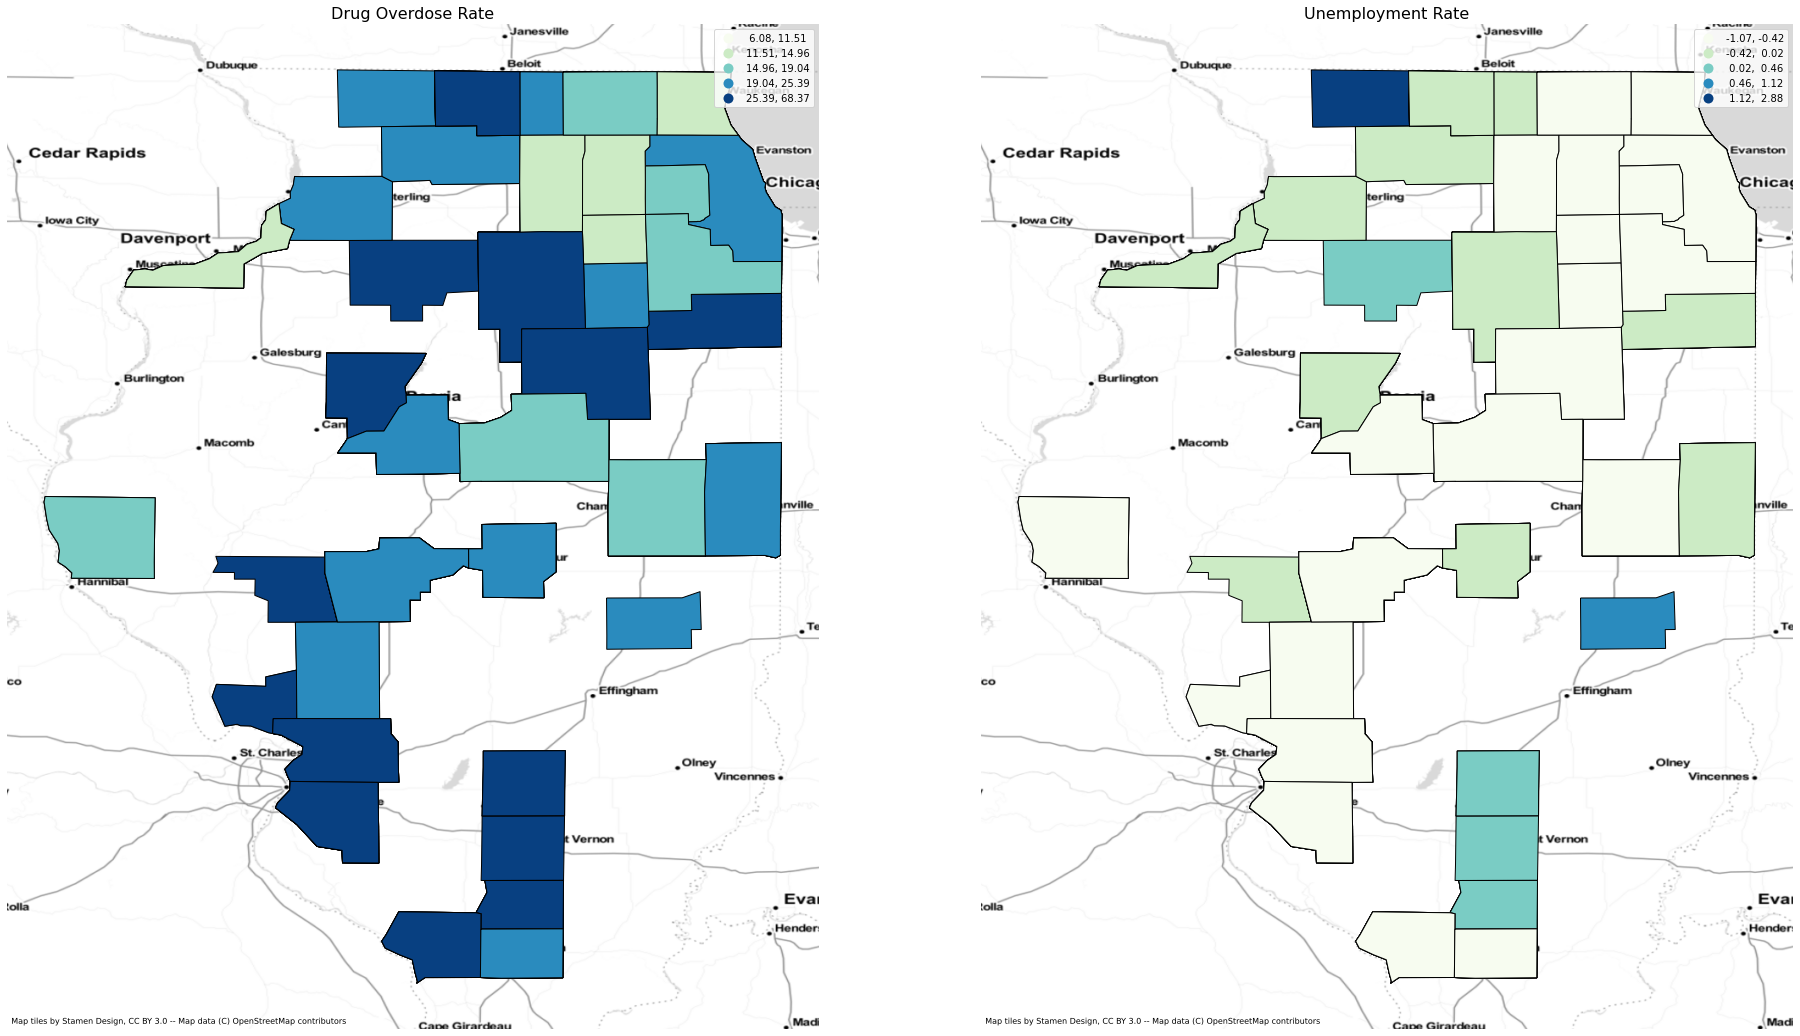

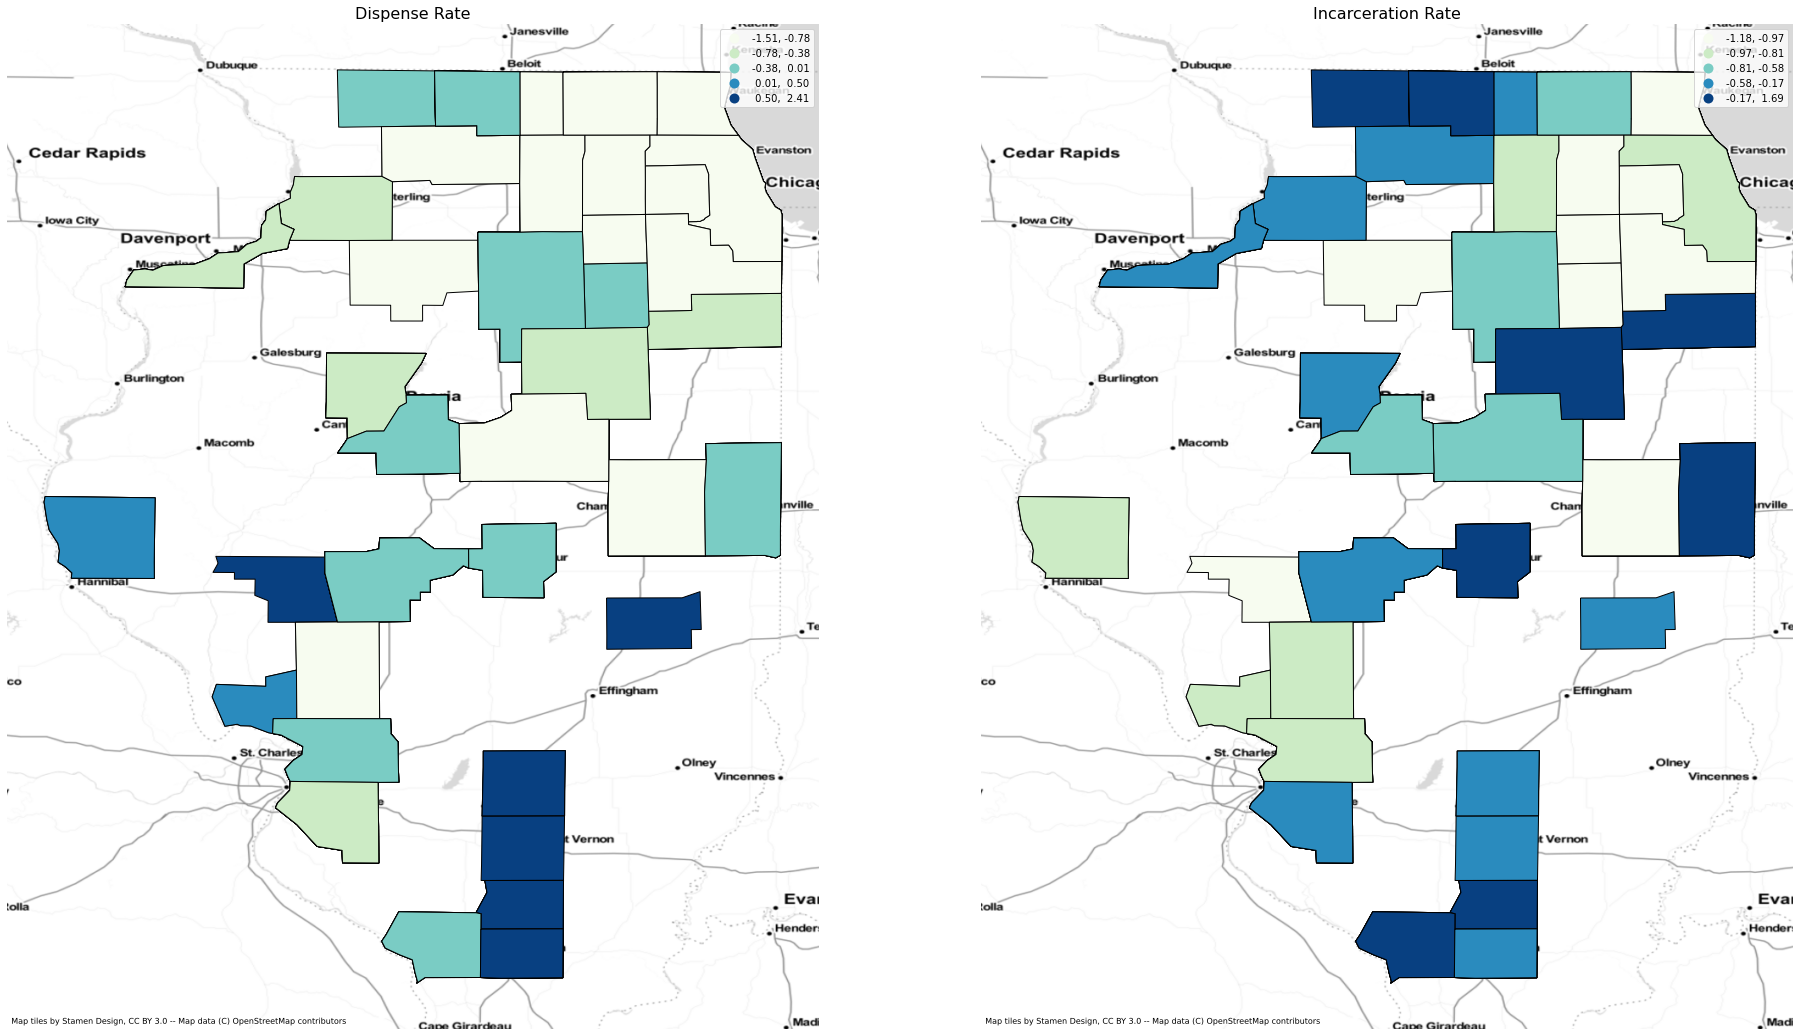

In [16]:
f,ax = plt.subplots(1,2,figsize=(32,34))

california.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

california.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

f,ax = plt.subplots(1,2,figsize=(32,34))
california.plot(column='Dispense_rate', legend=True, ax=ax[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[0].set_title("Dispense Rate", fontsize=16)

california.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

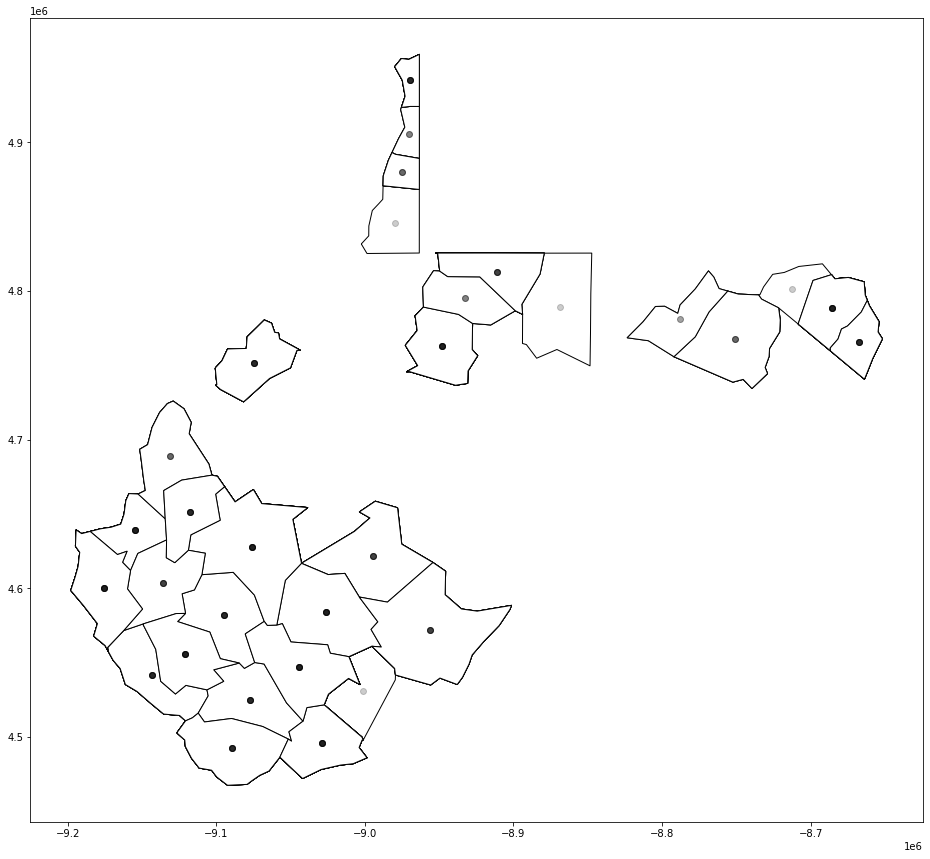

In [17]:
california = stzd_geogon[stzd_geogon['State'] == 'West Virginia']
california.crs = "EPSG:4326"
gdf_3857 = california.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

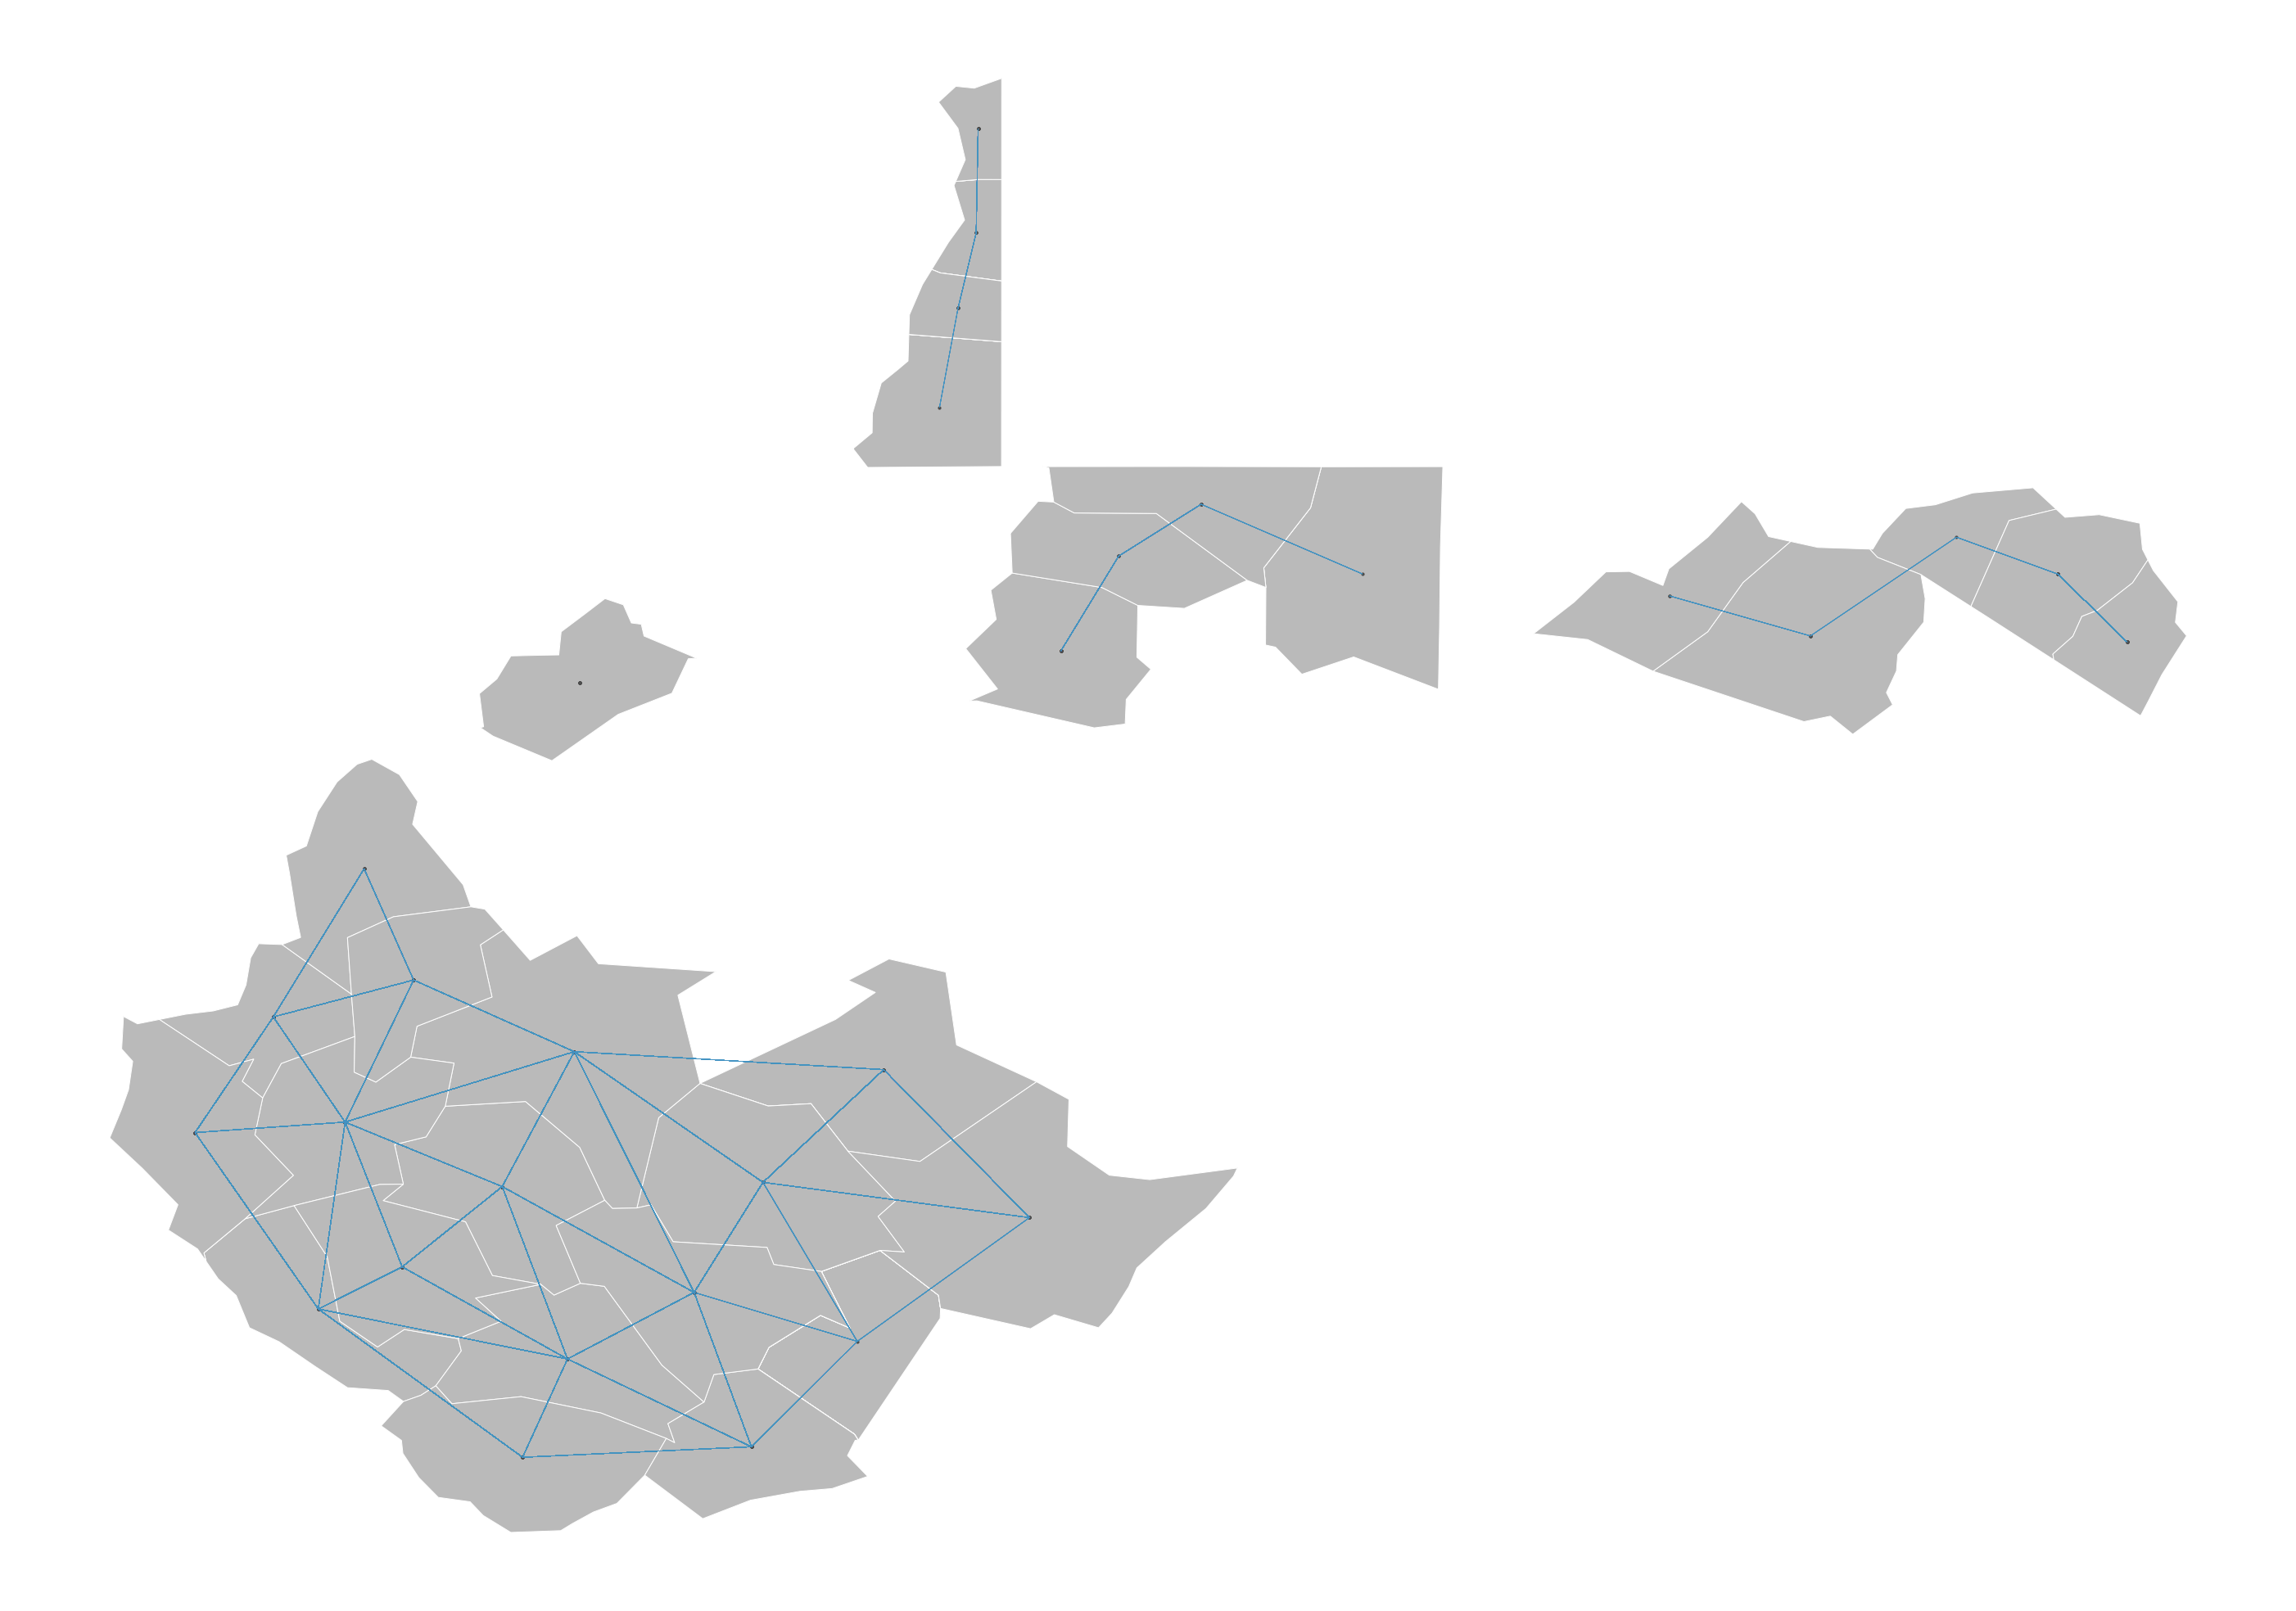

In [18]:
cali_df = stzd_geogon[stzd_geogon['State'] == 'West Virginia']
cali_w = Queen.from_dataframe(cali_df)
plot_spatial_weights(cali_w, cali_df, figsize = (50, 50))

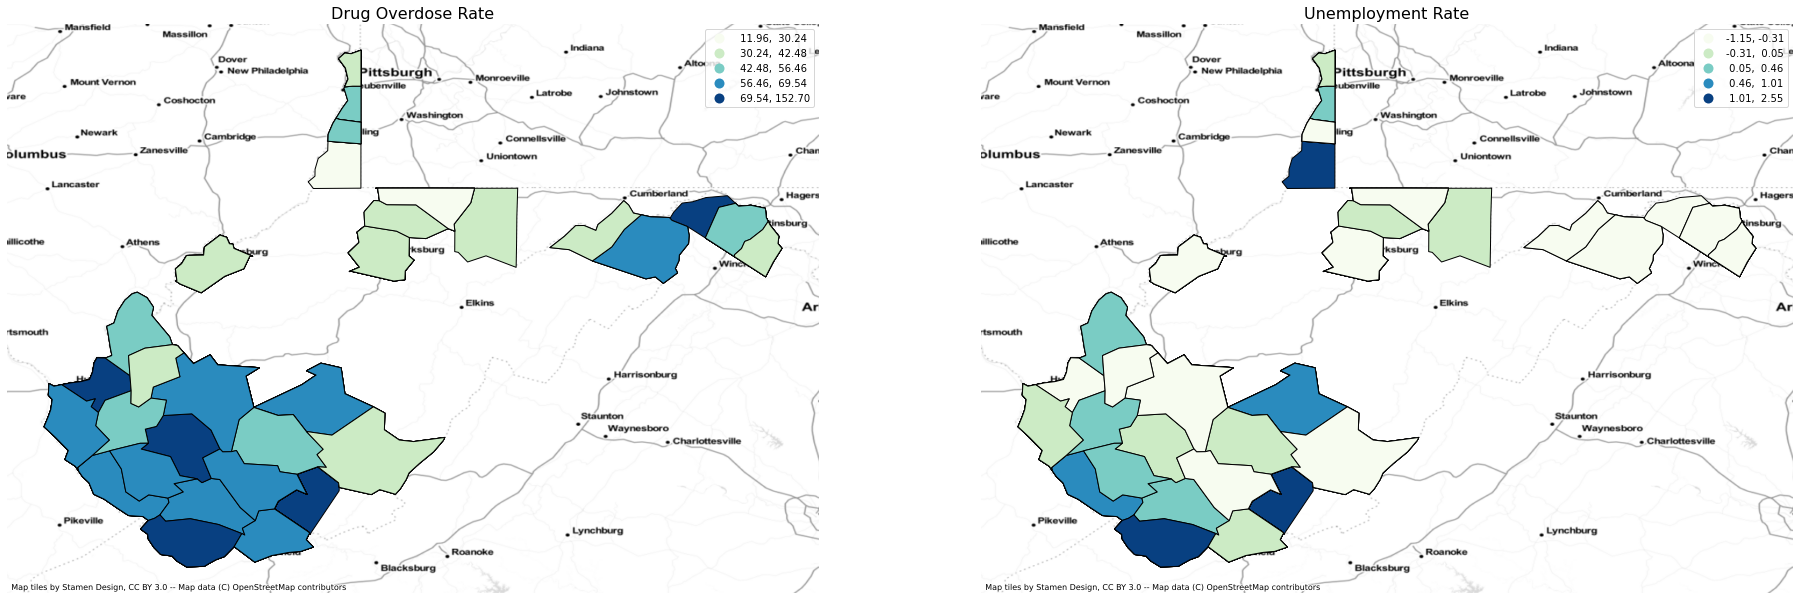

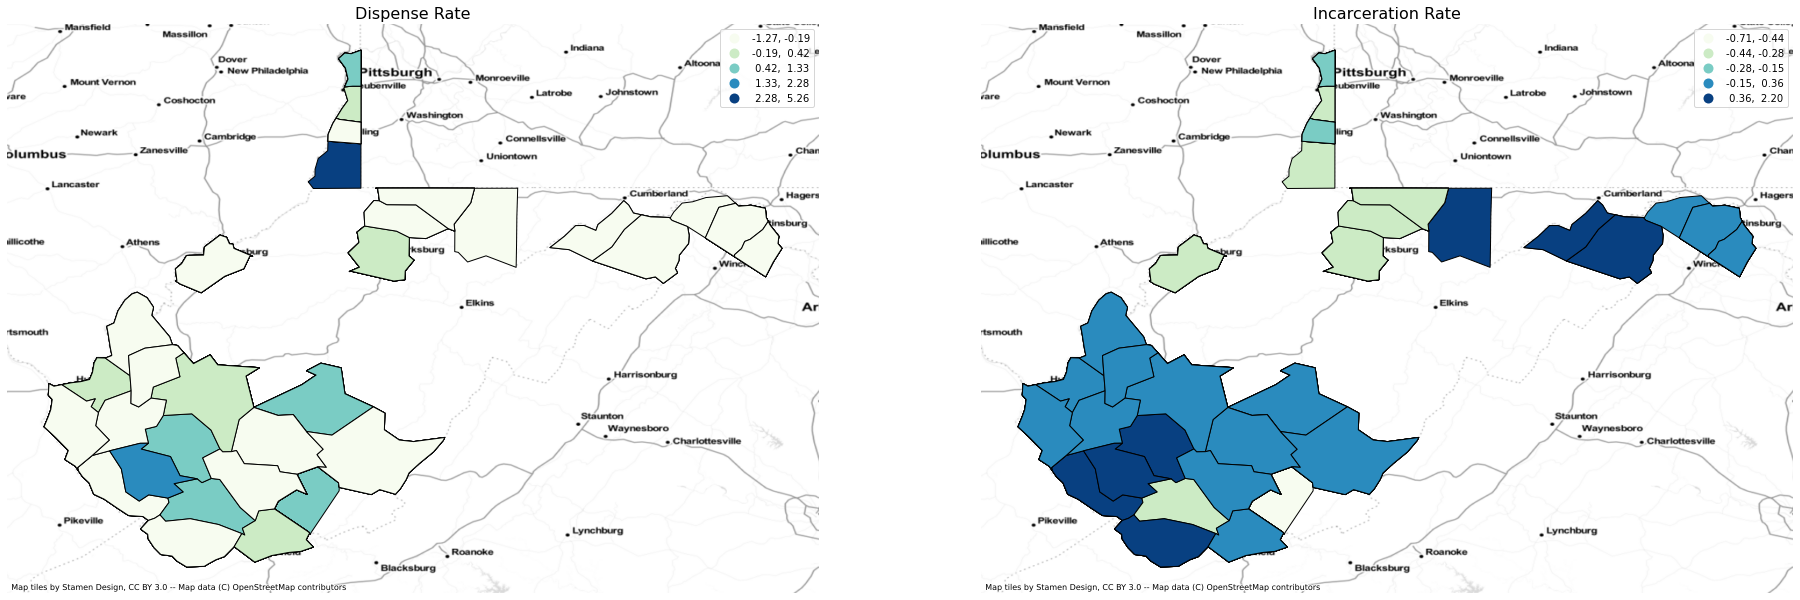

In [19]:
f,ax = plt.subplots(1,2,figsize=(32,34))

california.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

california.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

f,ax = plt.subplots(1,2,figsize=(32,34))
california.plot(column='Dispense_rate', legend=True, ax=ax[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[0].set_title("Dispense Rate", fontsize=16)

california.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

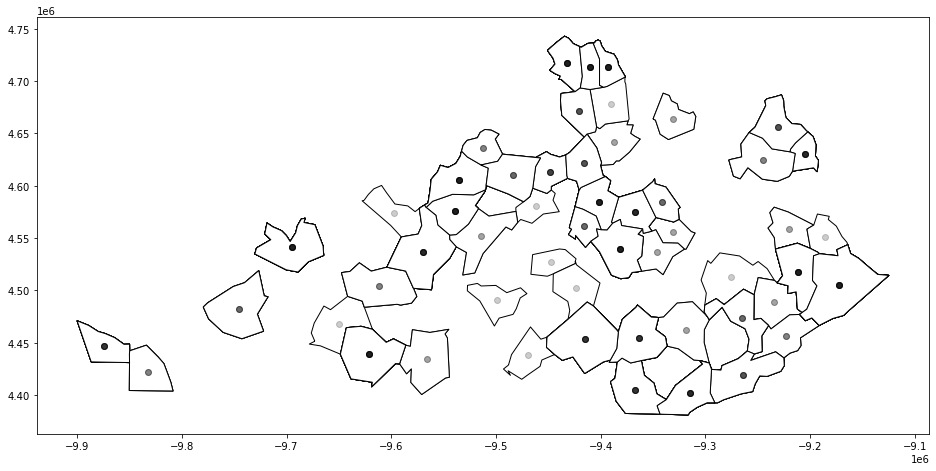

In [20]:
california = stzd_geogon[stzd_geogon['State'] == 'Kentucky']
california.crs = "EPSG:4326"
gdf_3857 = california.to_crs("EPSG:3857")
gdf_3857["x"] = gdf_3857.centroid.map(lambda p: p.x)
gdf_3857["y"] = gdf_3857.centroid.map(lambda p: p.y)
fig, ax = plt.subplots()
gdf_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
gdf_3857.centroid.plot(ax = ax, c = 'black', alpha = 0.2)
plt.show()

(<Figure size 3600x3600 with 1 Axes>, <AxesSubplot:>)

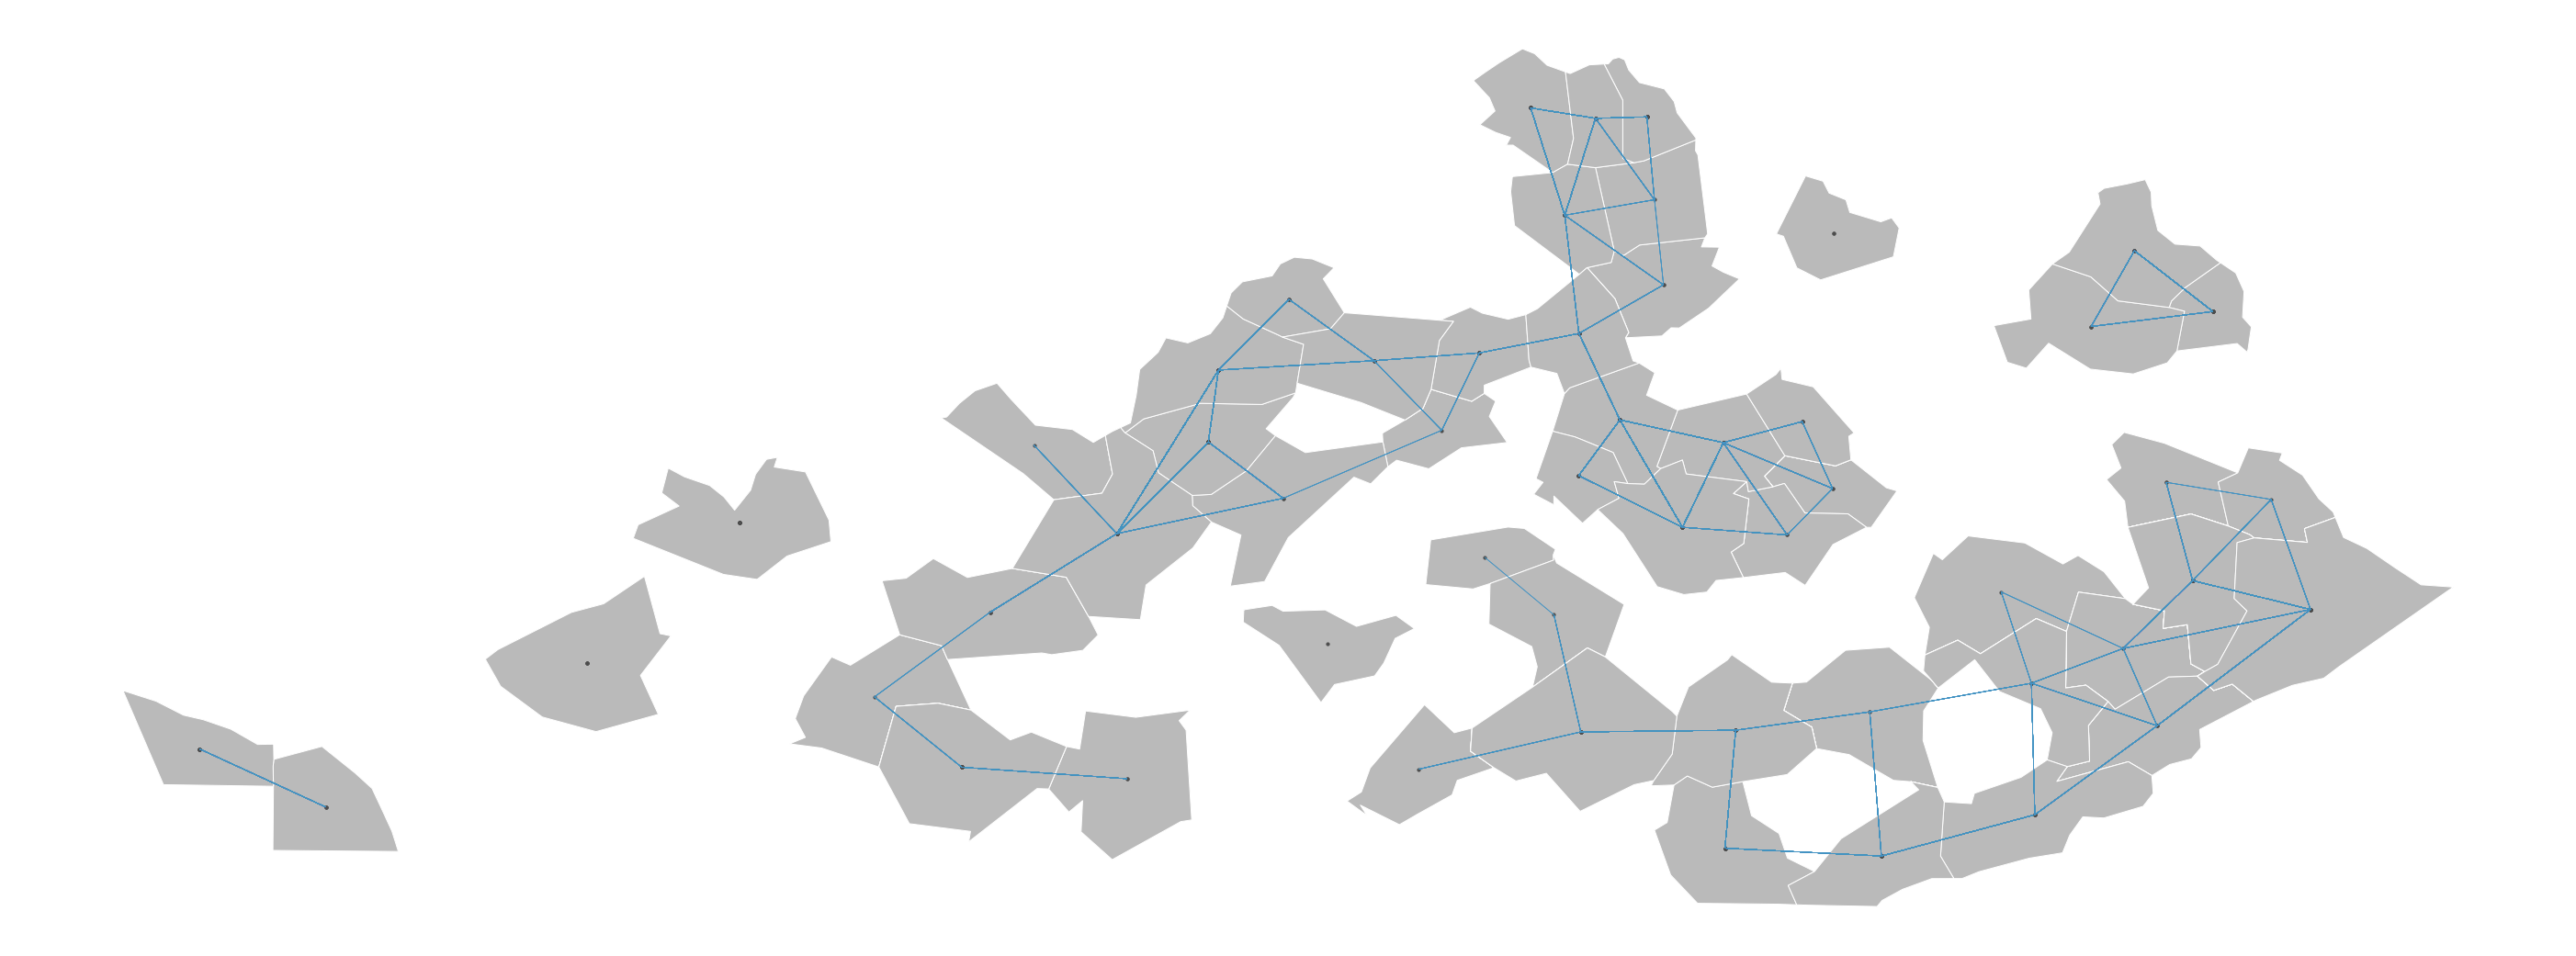

In [21]:
cali_df = stzd_geogon[stzd_geogon['State'] == 'Kentucky']
cali_w = Queen.from_dataframe(cali_df)
plot_spatial_weights(cali_w, cali_df, figsize = (50, 50))

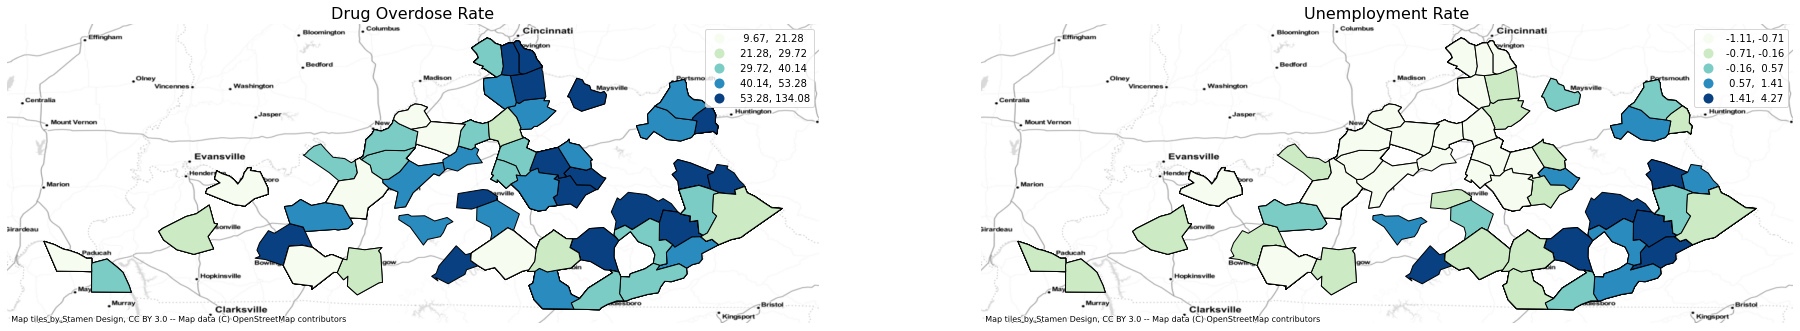

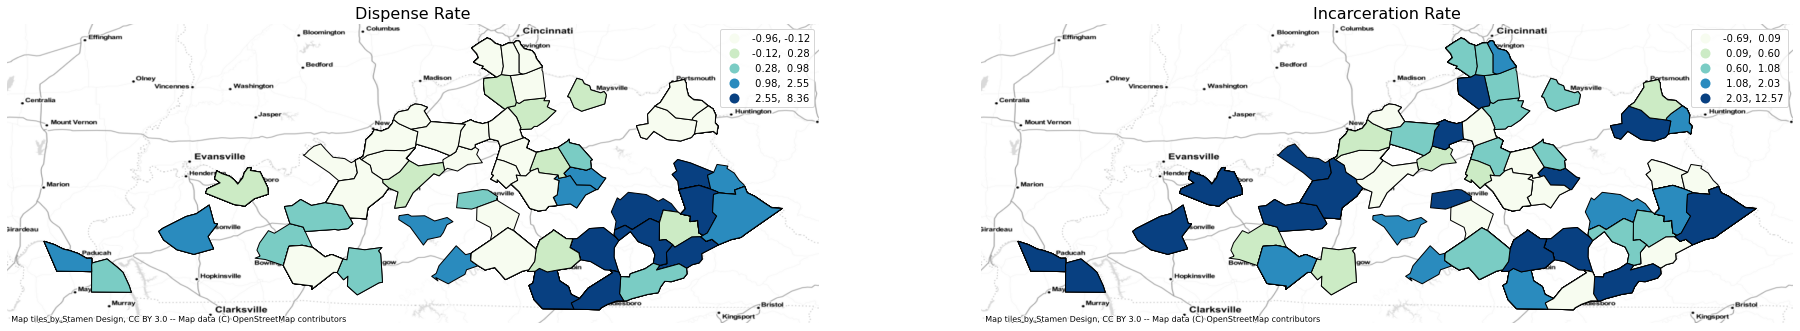

In [22]:
f,ax = plt.subplots(1,2,figsize=(32,34))

california.plot(column='Cruder_Rate', legend=True, ax=ax[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax[0].set_title("Drug Overdose Rate", fontsize=16)

california.plot(column='Unemployment_rate', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Unemployment Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

f,ax = plt.subplots(1,2,figsize=(32,34))
california.plot(column='Dispense_rate', legend=True, ax=ax[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[0].set_title("Dispense Rate", fontsize=16)

california.plot(column='Incarceration_Rate_per_100k', legend=True, ax=ax[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax[1].set_title("Incarceration Rate", fontsize=16)

ax[0].axis('off')
ax[1].axis('off')

cx.add_basemap(ax[0], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=california.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()